# **ch.09 텍스트를 위한 인공 신경망**  
## 09-3 LSTM과 GRU 셀  
### 풀어야 할 문제:  
> ### LSTM cell과 GRU cell에 대해 알아보기  

<br/>  

일반적으로 기본 recurrent cell은 긴 sequence를 학습하기 어려움  
$\because$ sequence가 길수록 순환되는 hidden state에 담긴 information이 점차 희석되기 때문  
&rarr; 긴 sequence일수록 멀리 떨어져 있는 word information을 인식하기 어려울 수 있음


이러한 문제점을 해결하기 위해 LSTM과 GRU cell이 개발됨

<br/>  
- - -  
<br/>  

### *LSTM 구조*  
LSTM
+ Long Short-Term Memory의 약자
+ short-term memory(단기 기억)를 오래 기억하기 위해 고안된 cell
+ input과 weights를 곱하고 intercepts를 더해 activation function에 통과시키는 structure를 여러 개 가지고 있음  
이러한 계산 결과는 다음 timestep에 재사용됨
+ 동작  
  + hidden state
    + input과 이전 timestep의 hidden state를 weights에 곱한 후 activation function에 통과시켜 hidden state를 만듦
    + activation function으로 기본 cell과 달리 sigmoid function을 사용
    + tanh function을 통과한 어떤 value(cell state)와 곱해져 hidden state를 만듦
  + cell state
    + hidden state와 비슷하게 cell 내부에서 순환되는 value
    + hidden state와 달리 다음 cell로 전달되지 않음
    + forget gate
      + cell state에 있는 information을 제거
      + input과 hidden state를 hidden state를 만들 때와는 다른 weights에 곱함
      + sigmoid function에 통과시킴
      + 이전 timestep의 cell state와 곱하여 cell state를 만듦
    + input gate
      + 새로운 information을 cell state에 추가
      + 두 개의 작은 cell로 이루어짐
      + input과 hidden state를 각기 다른 weights에 곱함
      + 하나의 cell은 sigmoid function에 통과시키고, 나머지 cell은 tanh function에 통과시킴
      + 두 결과를 곱함
      + 이전 cell state에 더함
  + output gate
    + 만들어진 cell state를 tanh function에 통과시킴
    + 새로운 hidden state에 곱해져 hidden state를 만드는 데 기여함

<br/>

LSTM은 작은 cell을 여러 개 포함하고 있는 큰 cell과 같은 structure를 가지고 있음  
주의할 점은 input과 hidden state에 곱해지는 weights, 작은 cell마다 적용되는 weigths는 모두 다르다는 점  
각각의 작은 cell은 각기 다른 기능을 위해 train됨

<br/>  
- - -  
<br/>  

### *LSTM 신경망 훈련하기*  

<br/>

data 준비하기
+ load IMDB review data
+ train set과 test set으로 나누기

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 0s 0us/step


+ sequence length를 100에 맞추기

In [3]:
from tensorflow import keras

train_seq = keras.utils.pad_sequences(train_input, maxlen=100)
val_seq = keras.utils.pad_sequences(val_input, maxlen=100)

LSTM cell을 사용한 RNN 만들기

In [4]:
model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model summary 확인

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`SimpleRNN` cell의 model parameter 개수는 200개  
`LSTM` cell에는 작은 cell이 4개 있으므로 기본 cell의 4배가 되어 800

<br/>  

compile model
+ RMSprop optimizer
+ binary cross entropy loss function
+ accuracy


train model
+ 100 epochs
+ 64 batch size
+ checkpoint, early stopping callbacks

In [6]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 28ms/step - loss: 0.6922 - accuracy: 0.5475 - val_loss: 0.6910 - val_accuracy: 0.5884
Epoch 2/100
 17/313 [>.............................] - ETA: 1s - loss: 0.6905 - accuracy: 0.6011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 3s 10ms/step - loss: 0.6883 - accuracy: 0.6158 - val_loss: 0.6848 - val_accuracy: 0.6504
Epoch 3/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6690 - accuracy: 0.6866 - val_loss: 0.6393 - val_accuracy: 0.7054
Epoch 4/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6065 - accuracy: 0.7071 - val_loss: 0.5942 - val_accuracy: 0.7132
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5795 - accuracy: 0.7254 - val_loss: 0.5744 - val_accuracy: 0.7260
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5612 - accuracy: 0.7418 - val_loss: 0.5594 - val_accuracy: 0.7406
Epoch 7/100
313/313 [==============================] - 2s 8ms/step - loss: 0.5451 - accuracy: 0.7556 - val_loss: 0.5476 - val_accuracy: 0.7454
Epoch 8/100
313/313 [==============================] - 3s 10ms/step - loss: 0.5310 - accuracy: 0.7648 - val_loss: 0.5327 - val_accuracy: 0.7570
Epoch 9

loss curve 그리기

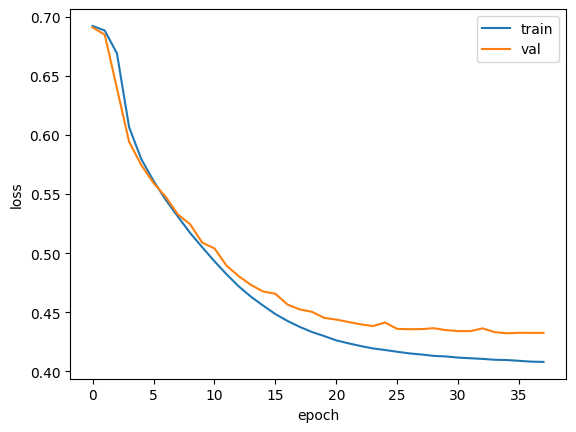

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

graph를 보면 기본 cell보다 LSTM이 overfitting을 잘 억제하며 training 수행했음을 알 수 있음

<br/>  
- - -  
<br/>  

### *순환층에 드롭아웃 적용하기*  

경우에 따라서 overfitting을 더 억제해야 할 필요도 있을 수 있음  
cell은 이를 위한 dropout을 자체적으로 제공함  
`SimpleRNN`과 `LSTM` class 모두 `dropout`, `recurrent_dropout` parameter를 통해 dropout을 설정할 수 있음
+ `dropout` parameter
  + cell의 input에 dropout을 적용
+ `recurrent_dropout` parameter
  + 순환되는 hidden state에 dropout을 적용
  + 기술적 문제로 인해 이를 사용하면 GPU를 사용하여 training을 진행하지 못함  
  &rarr; training 속도가 크게 느려짐

<br/>

`dropout` parameter를 사용하여 input에 대한 dropout 적용한 model 만들기

In [9]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

앞선 model과 동일한 조건으로 compile, train model

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 0.6924 - accuracy: 0.5344 - val_loss: 0.6920 - val_accuracy: 0.5598
Epoch 2/100
  8/313 [..............................] - ETA: 5s - loss: 0.6914 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 5s 15ms/step - loss: 0.6903 - accuracy: 0.5839 - val_loss: 0.6893 - val_accuracy: 0.6052
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6860 - accuracy: 0.6258 - val_loss: 0.6830 - val_accuracy: 0.6472
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6744 - accuracy: 0.6618 - val_loss: 0.6620 - val_accuracy: 0.6876
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6270 - accuracy: 0.7050 - val_loss: 0.5950 - val_accuracy: 0.7142
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.5851 - accuracy: 0.7156 - val_loss: 0.5740 - val_accuracy: 0.7250
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5649 - accuracy: 0.7343 - val_loss: 0.5533 - val_accuracy: 0.7468
Epoch 8/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5463 - accuracy: 0.7469 - val_loss: 0.5369 - val_accuracy: 0.7590
Epoch

loss curve 그리기

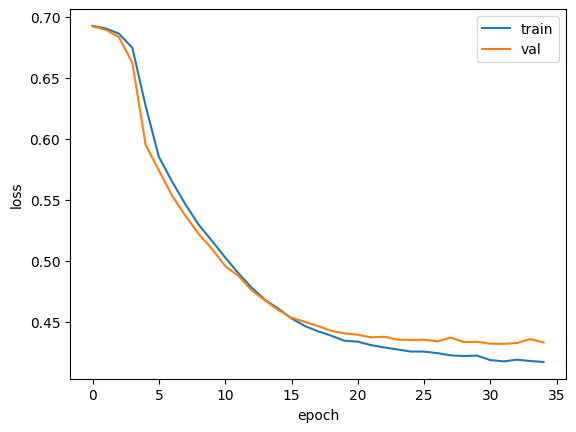

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

dropout이 overfitting을 잘 억제함

<br/>  
- - -  
<br/>  

### *2개의 층을 연결하기*  
LSTM cell도 여러 개를 쌓을 수 있음  

일반적으로 cell을 쌓으면 performance가 향상됨


앞서 기본 cell을 여러 개 쌓을 때도 이야기했지만, cell의 hidden state는 sequence의 마지막 timestep의 hidden state만 다음 layer로 전달함  
그러나 cell을 여러 개 쌓게 되면 모든 cell의 input으로 sequential data가 필요함  
$\therefore$ 마지막 cell을 제외한 모든 cell은 모든 timestep에 대한 hidden state를 출력해야 함


keras의 recurrnet layer에서 모든 timestep의 hidden state를 출력하려면 `retrun_sequences` parameter를 `True`로 지정

<br/>  

2개의 LSTM cell을 사용하는 RNN model 만들기

In [14]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model summary 확인

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


앞선 training 조건과 동일하게 compile, train model

In [16]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 35ms/step - loss: 0.6929 - accuracy: 0.5124 - val_loss: 0.6926 - val_accuracy: 0.5422
Epoch 2/100
  1/313 [..............................] - ETA: 6s - loss: 0.6923 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 5s 16ms/step - loss: 0.6919 - accuracy: 0.5490 - val_loss: 0.6910 - val_accuracy: 0.5924
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 0.6884 - accuracy: 0.6005 - val_loss: 0.6841 - val_accuracy: 0.6402
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6694 - accuracy: 0.6517 - val_loss: 0.6469 - val_accuracy: 0.6756
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6102 - accuracy: 0.6978 - val_loss: 0.5785 - val_accuracy: 0.7140
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5660 - accuracy: 0.7183 - val_loss: 0.5467 - val_accuracy: 0.7310
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5398 - accuracy: 0.7369 - val_loss: 0.5279 - val_accuracy: 0.7496
Epoch 8/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5207 - accuracy: 0.7500 - val_loss: 0.5046 - val_accuracy: 0.7608
Epoc

loss curve 그리기

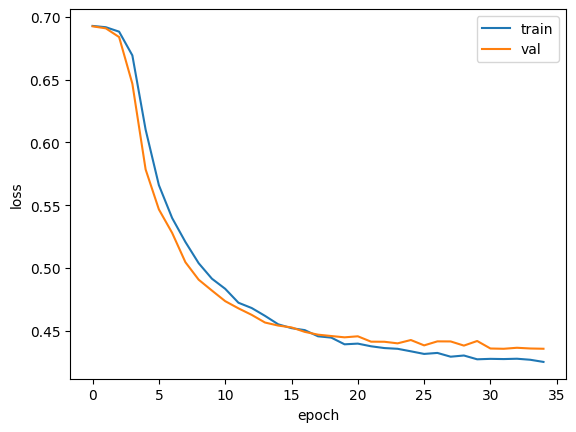

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

overfitting을 잘 억제하며 loss를 최대한 낮추었음

<br/>  
- - -  
<br/>  

### *GRU 구조*  
GRU
+ Gated Recurrent Unit의 약자
+ LSTM을 간소화한 것으로 생각할 수 있음
+ cell state를 계산하지 않음
+ 구조
  + input과 hidden state에 weights를 곱하고 intercepts를 더하는 3개의 작은 cell
  + 2개는 sigmoid function을 사용
  + 1개는 tanh function을 사용
+ 동작
  + forget gate
    + input과 hidden state에 weights를 곱함
    + sigmoid function을 통과함
    + hidden state에 바로 곱함
  + input gate
    + input되는 information을 control
    + 1에서 forget gate에 사용된 cell의 output을 뺀 value가 tanh function을 사용하는 cell의 output과 곱해짐
  + reset gate
    + hidden state의 information을 control
    + input과 hidden state에 weights를 곱함
    + sigmoid function을 통과함
    + tanh function을 사용하는 cell에 입력되는 hidden state에 곱해짐

<br/>  

GRU cell은 LSTM보다 weights 수가 적어 계산량이 적지만, LSTM 못지않은 좋은 performance를 보여줌

<br/>  
- - -  
<br/>  

### *GRU 신경망 훈련하기*  
GRU cell을 사용하는 RNN model 만들기

In [18]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model summary 확인

In [19]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8633 (33.72 KB)
Trainable params: 8633 (33.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


GRU cell의 model parameter 개수 계산
+ GRU cell에는 3개의 작은 cell이 있고, 이 cell들에는 input과 hidden state에 곱하는 weigths와 intercepts가 있음  
&rarr; 16 * 8 = 128, 8 * 8 = 64, 8  
$\therefore$ 128 + 64 + 8 = 200
+ 작은 cell이 3개 있음  
&rarr; 200 * 3 = 600  


그런데 summary를 보면 624개임  
tensorflow에 구현된 GRU cell은 앞선 설명과 조금 다름  
앞선 설명에서는 reset gate에 사용되는 cell의 output이 hidden state에 곱해진 후에 tanh function을 사용하는 cell에 data가 입력되었는데,  
tensorflow의 GRU에서는 hidden state가 cell의 output과 곱해지기 전에 먼저 weighs에 곱하고, 그 이후에 reset gate의 output이 곱해지고, 마지막에 input과 함께 weights와 reset gate cell의 output이 곱해진 hidden state가 또 다른 weights에 곱해져 tanh fucntion을 통과함  
&rarr; tanh function을 사용하는 cell의 weights가 나누어짐


이렇게 weights가 나누어지면 hidden state에 곱해지는 intercepts가 별도로 필요해짐  
&rarr; 작은 cell마다 하니씩 intercepts가 추가되고, neuron은 8개가 있으므로 3 * 8 = 24개의 parameter가 추가됨  
$\therefore$ GRU cell의 총 model parameter는 624개가 됨

<br/>  

compile model  
train model

In [20]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 21ms/step - loss: 0.6932 - accuracy: 0.4961 - val_loss: 0.6928 - val_accuracy: 0.5210
Epoch 2/100
 10/313 [..............................] - ETA: 4s - loss: 0.6928 - accuracy: 0.4969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 4s 12ms/step - loss: 0.6920 - accuracy: 0.5429 - val_loss: 0.6915 - val_accuracy: 0.5478
Epoch 3/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6903 - accuracy: 0.5609 - val_loss: 0.6898 - val_accuracy: 0.5622
Epoch 4/100
313/313 [==============================] - 4s 11ms/step - loss: 0.6881 - accuracy: 0.5729 - val_loss: 0.6874 - val_accuracy: 0.5758
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6848 - accuracy: 0.5832 - val_loss: 0.6839 - val_accuracy: 0.5830
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6803 - accuracy: 0.5981 - val_loss: 0.6793 - val_accuracy: 0.5900
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6742 - accuracy: 0.6072 - val_loss: 0.6730 - val_accuracy: 0.6032
Epoch 8/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6659 - accuracy: 0.6183 - val_loss: 0.6647 - val_accuracy: 0.6064
Epoc

LSTM cell을 사용한 model과 비슷한  performance

<br/>

loss curve 그리기

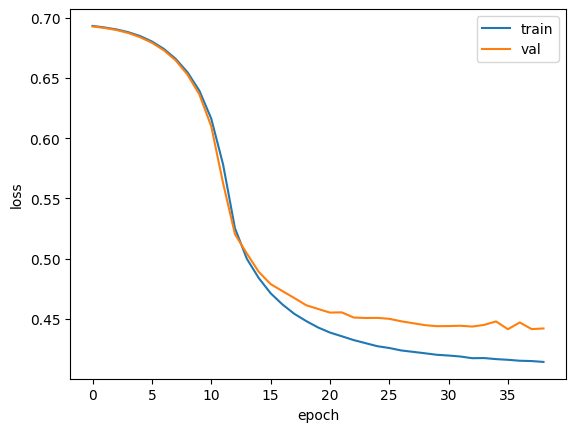

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

dropout을 적용하지 않아 LSTM을 사용한 model보다 overfitting된 경향이 있지만, 잘 train됨